# Utility functions

In [1]:
# convert hex string to unsigned int (es. FF00 -> 65280)
def hex2int_unsigned(hex_val):
    return int(hex_val,16)

# convert hex string to signed int (es. FF00 -> -256)
def hex2int_signed(hexval):
    bits = 16
    val = int(hexval, bits)
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val


# read text file into pandas DataFrame
def load_trc_file(file_name, skip_rows, n_rows = None):
    data_frame = pd.read_csv(
        file_name,
        delim_whitespace=True, 
        skiprows = skip_rows, 
        header=None, 
        names=["N","O","T","B","I","d","R","L","D0","D1","D2","D3","D4","D5","D6","D7"],
        nrows= n_rows,
        index_col = 'O',
        converters={
            'O': partial(pd.to_datetime,unit='ms',infer_datetime_format=True)
            #    'D0': partial(int, base=16),
        }
        
    )
    return data_frame

# extract posital values
def get_posital_data(data_frame, message_id):
    
    df1 = data_frame[data_frame["I"] == message_id]

    # convert angle from hex bytes to unsigned int
    df1['P2'] = (df1['D1'] + df1['D0']).apply(hex2int_unsigned)

    # resample at 10 milliseconds
    df1 = df1.resample("10L").ffill()

    return df1


def get_joystick_data(data_frame, message_id):
    # command = df[df["I"] == '02B2']
    df1 = data_frame[data_frame["I"] == message_id]

    # convert set points from hex strings to signed int
    df1['C2'] = (df1['D1'] + df1['D0']).apply(hex2int_signed)
    df1['C1'] = (df1['D3'] + df1['D2']).apply(hex2int_signed)

    # resample at 10 milliseconds
    df1 = df1.resample("10L").ffill()

    return df1


def merge_columns(cmd, pos, cmd_rolling_length = 1, pos_rolling_length = 1):

    min_rows = min(cmd.shape[0], pos.shape[0])

    cmd = cmd[['C1','C2']].iloc[0:min_rows].copy()
    cmd = cmd.rolling(cmd_rolling_length).mean()

    pos = pos[['P2']].iloc[0:min_rows].copy()
    pos = pos.rolling(pos_rolling_length).mean()

    df1 = pd.merge(cmd, pos, left_index=True, right_index=True)
    df1 = df1.dropna()

    return df1

def plot_joystick_and_position(df1):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    df1.plot(y=['P2'], ax=ax)
    df1.plot(y=["C1", "C2"], ax=ax2, ls="--")

    plt.show()


# constants
C1_BASE = 3  # start from columns 3
C1_STEP = 3  # take 3 steps back
C1_SIZE = 33 # was 33 in the ETH model

C2_BASE = C1_BASE+C1_SIZE  # start from columns 3+5
C2_STEP = 3  # take 3 steps back
C2_SIZE = 33 # was 33 in the ETH model


V_BASE = C1_BASE+C1_SIZE+C2_SIZE 
V_STEP = 1 # take 1 step back
V_SIZE = 10 # was 10 in the ETH model

def augment_columns(df3):
    # create columns with past commands
    for i in range(1,C1_SIZE+1):
        df3[C1_BASE+i] = df3['C1'].shift(i*C1_STEP)
        df3.rename(columns={C1_BASE+i:'C1-'+ str(i*C1_STEP)}, inplace=True)

    for i in range(1,C2_SIZE+1):
        df3[C2_BASE+i] = df3['C2'].shift(i*C2_STEP)
        df3.rename(columns={C2_BASE+i:'C2-'+ str(i*C2_STEP)}, inplace=True)

    # create velocities from positions
    df3['V2'] = df3['P2']-df3['P2'].shift(1)

    # filter velocities
    df3['V2'] = df3['V2'].rolling(velocity_rolling_length).mean()

    # create delta velocities from velocities
    # df3['DV2'] = df3['V2']-df3['V2'].shift(1)

    # create columns with past velocities
    for i in range(1,V_SIZE+1):
        df3[V_BASE+i] = df3['V2'].shift(i*V_STEP)
        df3.rename(columns={V_BASE+i:'V2-'+ str(i*V_STEP)}, inplace=True) 
    
    df3 = df3.fillna(0)

    return df3


# utility function
def plot_loss(hist, ymax=100):
  plt.plot(hist.history['loss'], label='loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.ylim([0, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)


def plot_predictions_vs_labels(test_preds, test_lbls, max_value=30):
    a = plt.axes(aspect='equal')
    plt.scatter(test_lbls, test_preds)
    plt.xlabel('True Values [y]')
    plt.ylabel('Predictions [y]')
    lims = [0, max_value]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)


def plot_prediction_error(err):
    plt.hist(err, bins=25)
    plt.xlabel('Prediction Error [y]')
    _ = plt.ylabel('Count')

# Load training File

## Load training file

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [3]:

# adjust these parameters

# data collection
# fname = "../input/posital-2-braccio/Posital 2 braccio.trc"
#fname = "../input/gru-dpx-posital-1-braccio-training/Gru_DPX_Posital_1_braccio_Training.trc"
train_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Test_Andrea.trc"

train_skip_rows = 20
train_n_rows = None

posital_message_id='0182'
joystick_message_id='02B1'

# data filter
joystick_rolling_length = 10
position_rolling_length = 10
velocity_rolling_length = 1

# keras model
labels_column_names = ['V2']
output_dimension = len(labels_column_names)
model_filename= './model_1'

In [4]:
# read text file into pandas DataFrame
df = load_trc_file(file_name=train_fname, skip_rows=train_skip_rows, n_rows=train_n_rows)
print(df)

                                N   T  B     I   d  R  L  D0  D1  D2  D3   D4  \
O                                                                               
1970-01-01 00:00:00.004358      5  DT  1  0182  Rx  -  8  DA  1E  91  01   91   
1970-01-01 00:00:00.004602      6  DT  1  0282  Rx  -  8  3B  01  00  00   01   
1970-01-01 00:00:00.005077      7  DT  1  03C4  Rx  -  8  B9  01  CF  01   2E   
1970-01-01 00:00:00.005316      8  DT  1  01C4  Rx  -  8  1B  03  93  02   05   
1970-01-01 00:00:00.012343      9  DT  1  0181  Rx  -  4  02  AB  B8  F5  NaN   
...                           ...  .. ..   ...  .. .. ..  ..  ..  ..  ..  ...   
1970-01-01 00:02:01.892487  83504  DT  1  03C4  Rx  -  8  21  01  66  03   2D   
1970-01-01 00:02:01.892728  83505  DT  1  01C4  Rx  -  8  02  02  9B  05   00   
1970-01-01 00:02:01.894728  83506  DT  1  0181  Rx  -  4  59  18  C9  B9  NaN   
1970-01-01 00:02:01.895802  83507  DT  1  0281  Rx  -  8  58  18  00  00   C8   
1970-01-01 00:02:01.897229  

In [5]:
# extract posital rows
posital = get_posital_data(df, message_id=posital_message_id)

# extract joystick rows
joystick = get_joystick_data(df, message_id=joystick_message_id)

<ipython-input-1-56e9e491a9cf>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['P2'] = (df1['D1'] + df1['D0']).apply(hex2int_unsigned)
<ipython-input-1-56e9e491a9cf>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['C2'] = (df1['D1'] + df1['D0']).apply(hex2int_signed)
<ipython-input-1-56e9e491a9cf>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

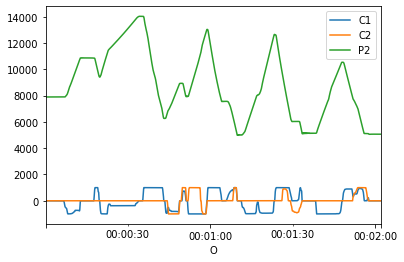

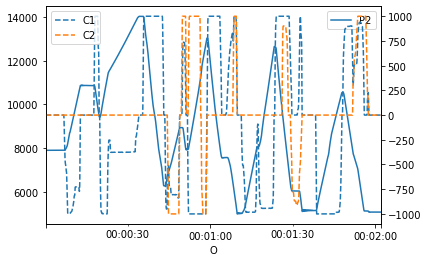

In [6]:
train_df2 = merge_columns(joystick, posital, joystick_rolling_length, position_rolling_length)
train_df2.plot()
plot_joystick_and_position(train_df2)

In [7]:
train_df2.describe()

C1 
 C2 
 P2 
 
 
 
 
 count 
 12169.000000 
 12169.000000 
 12169.000000 
 
 
 mean 
 -91.681321 
 37.842222 
 8810.101381 
 
 
 std 
 706.878994 
 404.555292 
 2527.639397 
 
 
 min 
 -1000.000000 
 -1000.000000 
 4983.400000 
 
 
 25% 
 -819.200000 
 0.000000 
 6871.200000 
 
 
 50% 
 0.000000 
 0.000000 
 8478.700000 
 
 
 75% 
 518.500000 
 0.000000 
 10860.600000 
 
 
 max 
 1000.000000 
 1000.000000 
 14044.000000

# Train KERAS Model

## Train KERAS Model

In [8]:
# create additional columns
train_df3 = train_df2.copy()
keras_dataset = augment_columns(train_df3)

In [9]:
# split dataset in train and test
train_dataset = keras_dataset.sample(frac=0.8, random_state=0)
test_dataset = keras_dataset.drop(train_dataset.index)

# extract features and labels into separate arrays
train_features = train_dataset.copy()
train_features = train_features.drop(labels_column_names, axis=1)
train_labels = train_dataset.loc[:, labels_column_names]

test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

print('\n', test_labels.columns, '\n', test_features.columns)


 Index(['V2'], dtype='object') 
 Index(['C1', 'C2', 'P2', 'C1-3', 'C1-6', 'C1-9', 'C1-12', 'C1-15', 'C1-18',
       'C1-21', 'C1-24', 'C1-27', 'C1-30', 'C1-33', 'C1-36', 'C1-39', 'C1-42',
       'C1-45', 'C1-48', 'C1-51', 'C1-54', 'C1-57', 'C1-60', 'C1-63', 'C1-66',
       'C1-69', 'C1-72', 'C1-75', 'C1-78', 'C1-81', 'C1-84', 'C1-87', 'C1-90',
       'C1-93', 'C1-96', 'C1-99', 'C2-3', 'C2-6', 'C2-9', 'C2-12', 'C2-15',
       'C2-18', 'C2-21', 'C2-24', 'C2-27', 'C2-30', 'C2-33', 'C2-36', 'C2-39',
       'C2-42', 'C2-45', 'C2-48', 'C2-51', 'C2-54', 'C2-57', 'C2-60', 'C2-63',
       'C2-66', 'C2-69', 'C2-72', 'C2-75', 'C2-78', 'C2-81', 'C2-84', 'C2-87',
       'C2-90', 'C2-93', 'C2-96', 'C2-99', 'V2-1', 'V2-2', 'V2-3', 'V2-4',
       'V2-5', 'V2-6', 'V2-7', 'V2-8', 'V2-9', 'V2-10'],
      dtype='object')


In [10]:
# show train_dataset mean and std
train_dataset.describe().transpose()

# create a Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)  # many variables
# normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None) #one variable

# set mean and std for Normalization layer
normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

In [11]:
# create keras model

dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(units=128, activation='relu'),
      layers.Dense(units = 128, activation='relu'),
      layers.Dense(units=128, activation='relu'),
      layers.Dense(output_dimension)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 79)               159       
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               10240     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,552
Trainable params: 43,393
Non-trainable params: 159
__________________________________________________

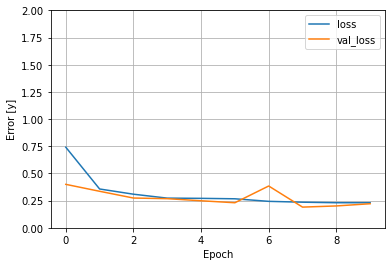

In [12]:
# train keras model

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=10
)

plot_loss(hist= history,ymax=2)

In [13]:
# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.2352624237537384

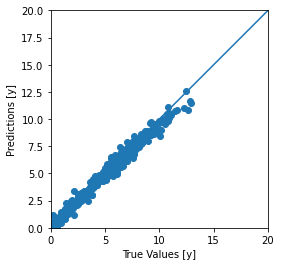

In [14]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)
plot_predictions_vs_labels(test_predictions, test_labels, max_value=20)

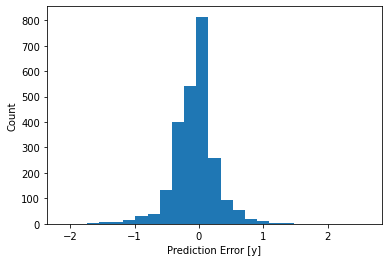

In [15]:
# evaluate predictions error
error = test_predictions - test_labels
plot_prediction_error(error)

([<matplotlib.lines.Line2D at 0x7f66d67d4bb0>], <AxesSubplot:xlabel='O'>)

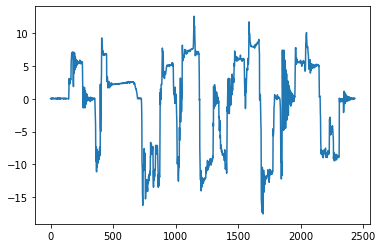

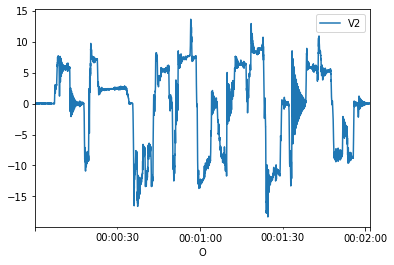

In [16]:
plt.plot(test_predictions), train_df3[labels_column_names].plot()

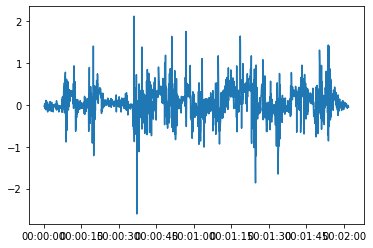

In [17]:
plt.plot(test_labels - test_predictions)

In [18]:
dnn_model.save(model_filename)
reloaded = tf.keras.models.load_model(model_filename)

INFO:tensorflow:Assets written to: ./model_1/assets


# Load test file

## Load test file

In [19]:
# adjust these parameters

# data collection
test_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Test_Moussa.trc"
test_skip_rows = 20
test_n_rows = None

In [20]:
# read text file into pandas DataFrame
df = load_trc_file(file_name=test_fname, skip_rows=test_skip_rows, n_rows=test_n_rows)
print(df)

                                N   T  B     I   d  R  L  D0  D1  D2  D3   D4  \
O                                                                               
1970-01-01 00:00:00.004208      5  DT  1  01C4  Rx  -  8  04  02  9B  05   00   
1970-01-01 00:00:00.008954      6  DT  1  0181  Rx  -  4  2D  18  9F  B9  NaN   
1970-01-01 00:00:00.010031      7  DT  1  0281  Rx  -  8  2D  18  00  00   9F   
1970-01-01 00:00:00.012036      8  DT  1  0182  Rx  -  8  BF  13  AE  FF   E1   
1970-01-01 00:00:00.012281      9  DT  1  0282  Rx  -  8  3B  01  FF  FF   06   
...                           ...  .. ..   ...  .. .. ..  ..  ..  ..  ..  ...   
1970-01-01 00:00:58.417004  40013  DT  1  01B1  Rx  -  8  01  00  00  00   00   
1970-01-01 00:00:58.417422  40014  DT  1  02B1  Rx  -  8  E8  03  7D  FE   00   
1970-01-01 00:00:58.422630  40015  DT  1  0181  Rx  -  4  A9  A7  05  F9  NaN   
1970-01-01 00:00:58.423376  40016  DT  1  03C4  Rx  -  8  BF  01  F2  01   2B   
1970-01-01 00:00:58.423617  

In [21]:
# extract posital rows
test_pos = get_posital_data(df, message_id=posital_message_id)

# extract joystick rows
test_joy = get_joystick_data(df, message_id=joystick_message_id)

<ipython-input-1-56e9e491a9cf>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['P2'] = (df1['D1'] + df1['D0']).apply(hex2int_unsigned)
<ipython-input-1-56e9e491a9cf>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['C2'] = (df1['D1'] + df1['D0']).apply(hex2int_signed)
<ipython-input-1-56e9e491a9cf>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

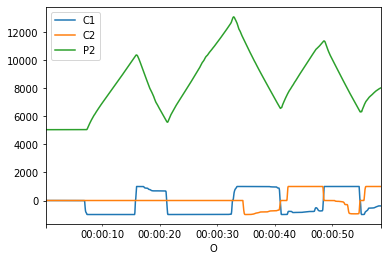

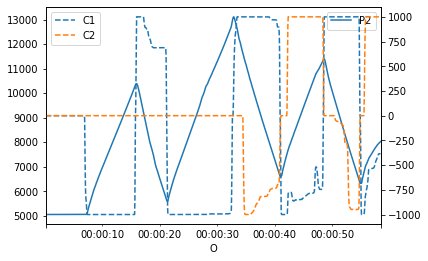

In [22]:
test_df2 = merge_columns(test_joy, test_pos, joystick_rolling_length, position_rolling_length)
test_df2.plot()
plot_joystick_and_position(test_df2)

# Evaluate test file

## Evaluate test file

In [23]:
test_df2

C1 
 C2 
 P2 
 
 
 O 
 
 
 
 
 
 
 
 1970-01-01 00:00:00.110 
 0.0 
 0.0 
 5055.6 
 
 
 1970-01-01 00:00:00.120 
 0.0 
 0.0 
 5055.7 
 
 
 1970-01-01 00:00:00.130 
 0.0 
 0.0 
 5055.8 
 
 
 1970-01-01 00:00:00.140 
 0.0 
 0.0 
 5055.9 
 
 
 1970-01-01 00:00:00.150 
 0.0 
 0.0 
 5056.0 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 1970-01-01 00:00:58.370 
 -386.6 
 1000.0 
 8016.3 
 
 
 1970-01-01 00:00:58.380 
 -386.7 
 1000.0 
 8018.7 
 
 
 1970-01-01 00:00:58.390 
 -386.8 
 1000.0 
 8021.1 
 
 
 1970-01-01 00:00:58.400 
 -386.9 
 1000.0 
 8023.6 
 
 
 1970-01-01 00:00:58.410 
 -387.0 
 1000.0 
 8026.0 
 
 
 
 5831 rows × 3 columns

In [24]:
# create additional columns
test_df3 = test_df2.copy()
keras_dataset = augment_columns(test_df3)
print(keras_dataset)

                            C1      C2      P2   C1-3   C1-6   C1-9  C1-12  \
O                                                                            
1970-01-01 00:00:00.110    0.0     0.0  5055.6    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.120    0.0     0.0  5055.7    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.130    0.0     0.0  5055.8    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.140    0.0     0.0  5055.9    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.150    0.0     0.0  5056.0    0.0    0.0    0.0    0.0   
...                        ...     ...     ...    ...    ...    ...    ...   
1970-01-01 00:00:58.370 -386.6  1000.0  8016.3 -386.1 -385.5 -384.9 -384.7   
1970-01-01 00:00:58.380 -386.7  1000.0  8018.7 -386.3 -385.7 -385.1 -384.5   
1970-01-01 00:00:58.390 -386.8  1000.0  8021.1 -386.5 -385.9 -385.3 -384.7   
1970-01-01 00:00:58.400 -386.9  1000.0  8023.6 -386.6 -386.1 -385.5 -384.9   
1970-01-01 00:00:58.410 -387.0  1000.0  8026.0 -386.7 -386.3 -38

In [25]:
# use the whole file for testing, there is no training phase

# split dataset in train and test
test_dataset = keras_dataset.copy()

# extract features and labels into separate arrays
test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

In [26]:
# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.3443351984024048

In [27]:
test_features

C1 
 C2 
 P2 
 C1-3 
 C1-6 
 C1-9 
 C1-12 
 C1-15 
 C1-18 
 C1-21 
 ... 
 V2-1 
 V2-2 
 V2-3 
 V2-4 
 V2-5 
 V2-6 
 V2-7 
 V2-8 
 V2-9 
 V2-10 
 
 
 O 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1970-01-01 00:00:00.110 
 0.0 
 0.0 
 5055.6 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1970-01-01 00:00:00.120 
 0.0 
 0.0 
 5055.7 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1970-01-01 00:00:00.130 
 0.0 
 0.0 
 5055.8 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1970-01-01 00:00:00.140 
 0.0 
 0.0 
 5055.9 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.1 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1970-01-01 00:00:00.150 
 0.0 
 0.0 
 5056.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.1 
 0.1 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1970-01-01 00:00:58.370 
 -386.6 
 1000.0 
 8016.3 
 -386.1 
 -385.5 
 -384.9 
 -384.7 
 -385.3 
 -385.7 
 -386.0 
 ... 
 2.4 
 2.5 
 2.4 
 2.4 
 2.4 
 2.4 
 2.3 
 2.3 
 2.2 
 2.2 
 
 
 1970-01-01 00:00:58.380 
 -386.7 
 1000.0 
 8018.7 
 -386.3 
 -385.7 
 -385.1 
 -384.5 
 -385.1 
 -385.6 
 -385.9 
 ... 
 2.3 
 2.4 
 2.5 
 2.4 
 2.4 
 2.4 
 2.4 
 2.3 
 2.3 
 2.2 
 
 
 1970-01-01 00:00:58.390 
 -386.8 
 1000.0 
 8021.1 
 -386.5 
 -385.9 
 -385.3 
 -384.7 
 -384.9 
 -385.5 
 -385.8 
 ... 
 2.4 
 2.3 
 2.4 
 2.5 
 2.4 
 2.4 
 2.4 
 2.4 
 2.3 
 2.3 
 
 
 1970-01-01 00:00:58.400 
 -386.9 
 1000.0 
 8023.6 
 -386.6 
 -386.1 
 -385.5 
 -384.9 
 -384.7 
 -385.3 
 -385.7 
 ... 
 2.4 
 2.4 
 2.3 
 2.4 
 2.5 
 2.4 
 2.4 
 2.4 
 2.4 
 2.3 
 
 
 1970-01-01 00:00:58.410 
 -387.0 
 1000.0 
 8026.0 
 -386.7 
 -386.3 
 -385.7 
 -385.1 
 -384.5 
 -385.1 
 -385.6 
 ... 
 2.5 
 2.4 
 2.4 
 2.3 
 2.4 
 2.5 
 2.4 
 2.4 
 2.4 
 2.4 
 
 
 
 5831 rows × 79 columns

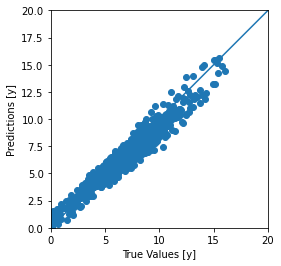

In [28]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)
plot_predictions_vs_labels(test_predictions, test_labels, max_value=20)

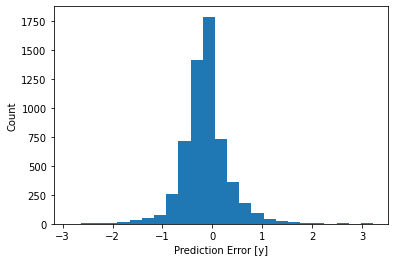

In [29]:
# evaluate predictions error
error = test_predictions - test_labels
plot_prediction_error(error)

([<matplotlib.lines.Line2D at 0x7f66d6aa7d00>], <AxesSubplot:xlabel='O'>)

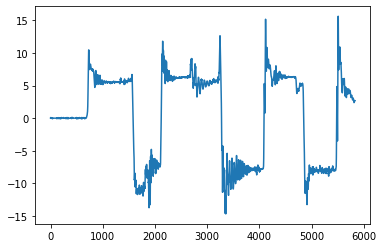

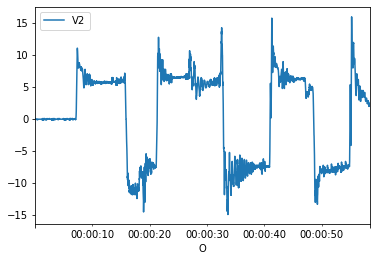

In [30]:
plt.plot(test_predictions),test_df3[labels_column_names].plot()

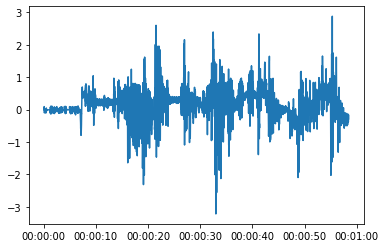

In [31]:
plt.plot(test_labels - test_predictions)

# Predict

In [32]:
pred_model_filename = 'model_1'

#cmd_1 = [0, 0, 0, 0, 0, 0, 1000, 1000, 1000, 1000, -1000, -1000, -1000, -1000]
cmd_1 = 1000 * np.ones(1000)
for i in range(0,100): cmd_1[i] = 0
for i in range(900,1000): cmd_1[i] = 0

cmd_2 = np.zeros_like(cmd_1)
pos_2 = np.zeros_like(cmd_1)
  

# Calling DataFrame constructor after zipping both lists, with columns specified
pred_df2 = pd.DataFrame(list(zip(cmd_1, cmd_2, pos_2)),
               columns =['C1', 'C2', 'P2'])
pred_df2

C1 
 C2 
 P2 
 
 
 
 
 0 
 0.0 
 0.0 
 0.0 
 
 
 1 
 0.0 
 0.0 
 0.0 
 
 
 2 
 0.0 
 0.0 
 0.0 
 
 
 3 
 0.0 
 0.0 
 0.0 
 
 
 4 
 0.0 
 0.0 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 995 
 0.0 
 0.0 
 0.0 
 
 
 996 
 0.0 
 0.0 
 0.0 
 
 
 997 
 0.0 
 0.0 
 0.0 
 
 
 998 
 0.0 
 0.0 
 0.0 
 
 
 999 
 0.0 
 0.0 
 0.0 
 
 
 
 1000 rows × 3 columns

In [33]:
reloaded_model = tf.keras.models.load_model(pred_model_filename)
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 79)               159       
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               10240     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,552
Trainable params: 43,393
Non-trainable params: 159
__________________________________________________

In [34]:
pred_df3 = pred_df2.copy()
pred_keras_dataset = augment_columns(pred_df3)
pred_keras_dataset

C1 
 C2 
 P2 
 C1-3 
 C1-6 
 C1-9 
 C1-12 
 C1-15 
 C1-18 
 C1-21 
 ... 
 V2-1 
 V2-2 
 V2-3 
 V2-4 
 V2-5 
 V2-6 
 V2-7 
 V2-8 
 V2-9 
 V2-10 
 
 
 
 
 0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 2 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 3 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 4 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 995 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 996 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 997 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 998 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 999 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 
 1000 rows × 80 columns

In [35]:
pred_dataset = pred_keras_dataset.copy()

# extract features and labels into separate arrays
pred_features = pred_dataset.copy()
pred_features = pred_features.drop(labels_column_names, axis=1)
pred_labels = pred_dataset.loc[:, labels_column_names]

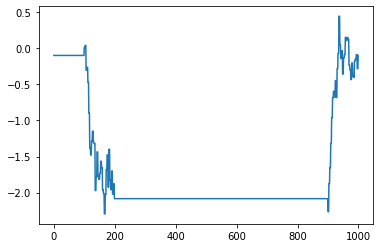

In [36]:
pred_predictions = reloaded_model.predict(pred_features)
plt.plot(pred_predictions)